<a href="https://colab.research.google.com/github/IdaCy/mech-typo-detect/blob/main/typo_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability of Typo vs. Clean Prompts
**Author**: Ida Caspary (Imperial College London)

## Introduction

The purpose of this notebook is to explore mechanistic interpretability of a large language model when it is fed prompts with small typographical errors. We want to see:
- How hidden layers and attention distributions are affected by a single typo in the prompt.
- How differences in activation patterns might shed light on how the model handles (or mis-handles) these noise inputs.

We have **5,000 pairs** of prompts: one “clean” version and one **“typo”** version where exactly one token has been altered. For each prompt pair, we extracted from HPC runs:
- Hidden states at layers `[0, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 31]`.
- Final logits & probabilities from layer 31.
- Predictions, tokenization.

We also have **difference files** (clean vs. typo) stored in `analyses_results/differences/activations_*.pt`.

In this notebook, we will:
1. Load these `.pt` files and inspect the differences.
2. Perform PCA on the activation differences to see if there's a low-dimensional “typo signal.”
3. Look at correlation, variance, and which neurons shift the most under typos.
4. Explore ideas for analyzing mechanistic reasons behind these differences.

**Note:** Some surprising initial results (e.g., extremely high explained variance in the first principal component for certain layers) indicate that the “typo difference” might be dominated by a few outlier neurons. We will investigate this further.


## Notebook Setup & Dependencies

Below, we install or import all the necessary libraries. And, get the modules from the GitHub repository.


In [ ]:
# Check Python version (optional):
import sys
print("Python version:", sys.version)

# Get installations
!pip install --quiet torch numpy matplotlib scikit-learn
!pip install --quiet huggingface_hub transformers

# Clone and get into directory from github
!git clone https://github.com/IdaCy/mech-typo-detect.git
%cd mech-typo-detect

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# If you want to check GPU usage:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
Cloning into 'mech-typo-detect'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.environ["HF_API_TOKEN"] = "XXX"

Mounted at /content/drive


## Running Inference on Clean vs. Typo Prompts

Now that we've set up the environment and verified our imports, we can move on to the actual inference step. In our repository, there's a script inside `scripts/mistral/` that performs inference on the model, generating hidden states, logits, etc.

In [1]:
!python scripts/mistral/inference.py

Model loaded successfully.
Loaded 5000 samples for inference.
Starting inference & extraction of relevant activations for clean & typo prompts...
Saved activations for samples 0 to 8
Saved activations for samples 1000 to 1008
Saved activations for samples 2000 to 2008
Saved activations for samples 3000 to 3008
Saved activations for samples 4000 to 4008
Inference complete. Results saved in 'extractions'.


## Step 1: Compute Differences Between Clean & Typo
This script, `1_diffs_compute.py`, reads combined activation files (in `big_extractions`) that contain both the “clean” and “typo” data. It then computes the differences (clean minus typo) for each relevant key (hidden states, attention scores, logits, etc.) and saves them in `analyses_results/big_differences`.

**Key Points**:
- Input directory: `extractions`
- Output directory: `analyses_results/differences`
- Loops through each `.pt` file and subtracts `typo` from `clean`.

In [2]:
!python scripts/analyses/1_diffs_compute.py

Found 5000 files in extractions


Processing extraction files: 100%|██████████| 5000/5000 [00:00<00:00, 5621.60it/s]


## Step 2: Perform PCA on the Differences
`2_pca_pc1.py` takes the difference files from `analyses_results/differences` (or wherever you placed them) and:
1. Loads each difference file in parallel.
2. Extracts the difference vectors from each layer.
3. Runs PCA (with 10 components) and stores the PCA results and the first principal component (PC1) vector.
4. Plots how much variance PC1 explains per layer.

**Key Points**:
- Input directory: `analyses_results/differences`
- Output directory: `analyses_results/PCA_PC1` (for both numeric `.pt` files and a `pca_plot.png`).
- You can control `max_samples` for memory use.


In [4]:
!python scripts/analyses/2_pca_pc1.py

Total difference files found: 5000 Layer keys detected: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_10', 'layer_15', 'layer_20', 'layer_25', 'layer_30', 'layer_31'] 
PCA results saved to analyses_results/PCA_PC1/layer_pca_results.pt 
PC1 vectors saved to analyses_results/PCA_PC1/layer_pc1_vectors.pt


In [25]:
!git clone https://github.com/IdaCy/mech-typo-detect.git
%cd mech-typo-detect

%ls analyses_results/

Cloning into 'mech-typo-detect'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 133 (delta 50), reused 115 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 1.82 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/mech-typo-detect/mech-typo-detect/mech-typo-detect
neuron_activation_diff_hist.png     PCA_PC1/          PCA_PC1_repeated/
neuron_letters_changed_scatter.png  PCA_PC1_missing/  PCA_PC1_swapped/


## Step 3: Check PCA Results
Finally, `3_pca_check.py` will:
1. Load the PCA results (`layer_pca_results.pt`) and PC1 vectors (`layer_pc1_vectors.pt`).
2. Print a summary of each layer’s top 10 explained variance ratios.
3. Show the shape of the PC1 vectors (and optionally prints a few elements).
4. Create a quick plot of PC1 explained variance ratio across layers.

**Key Points**:
- Reads from `analyses_results/PCA_PC1/layer_pca_results.pt` and `layer_pc1_vectors.pt`.
- Plots the explained variance for PC1 per layer.
- Displays the figure in the notebook.

=== PCA Results Summary ===
Type of PCA results: <class 'dict'> Type of PC1 vectors: <class 'dict'>
Total layers: 14

Layer layer_0: Explained variance ratios (top 3): [0.04447212 0.02568739 0.02283133] | First 3 elements: [-0.01475475 -0.00424211 -0.03147998]

Layer layer_1: Explained variance ratios (top 3): [0.9649772  0.0016532  0.00128761] | First 3 elements: [0.0001291  0.00025615 0.03089947]

Layer layer_2: Explained variance ratios (top 3): [9.9996758e-01 3.8787971e-06 2.6100363e-06] | First 3 elements: [0.00044978 0.00152085 0.00053959]

Layer layer_3: Explained variance ratios (top 3): [9.9990422e-01 6.5014933e-06 3.7147388e-06] | First 3 elements: [0.00047433 0.00153232 0.00055048]

Layer layer_4: Explained variance ratios (top 3): [9.9984980e-01 1.4032689e-05 4.7625426e-06] | First 3 elements: [0.00048923 0.00152234 0.00057472]

Layer layer_5: Explained variance ratios (top 3): [9.9970543e-01 2.0767673e-05 8.8691031e-06] | First 3 elements: [0.00049341 0.00155532 0.00056146

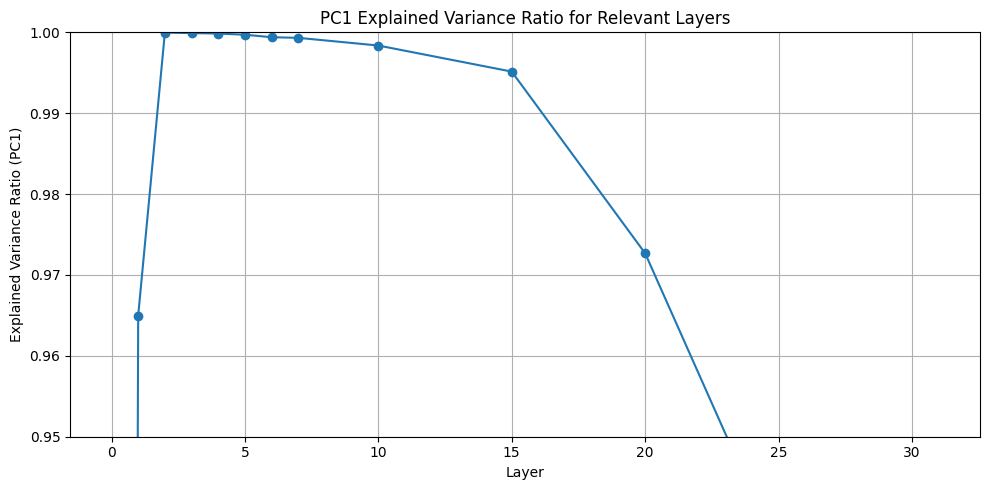

<Figure size 640x480 with 0 Axes>

In [26]:
%run scripts/analyses/3_pca_check.py

## Investigating Neuron Groups via PCA

In this step, we run a script that performs the following:

1. **Loads difference files** (clean vs. typo) from a specified directory (`analyses_results/differences` by default).
2. **Extracts the hidden-state differences** for a particular layer (e.g. `layer_0`), converting them from `bfloat16` to `float32`.
3. **Optionally subsamples** if we have more tokens than we want to handle in memory.
4. **Runs PCA** (with `n_components=5`) on the stacked difference vectors.
5. **Prints**:
   - The explained variance ratio for each principal component (PC1 to PC5).
   - The top neuron indices for PC1 (the neurons that have the largest absolute component values).

By default, it runs PCA for `layer_0`, and can then add further layers in sequence. It is currently set to add analyses for layers 1, 2, and 3.

**Key points to note**:
- `DIFFERENCES_DIR`: points to `analyses_results/differences` where your `.pt` difference files live.
- `LAYER_NAME`: currently set to `"layer_0"`, but we also call `run_pca_for_layer(...)` for layers 1, 2, and 3 inside `main()`.
- `MAX_FILES`, `SUBSAMPLE`, and `N_COMPONENTS` let you control how much data you load and how many PCA components you compute.
- After each PCA run, it prints out the top 5 neurons (by absolute PC1 contribution). Feel free to adjust the number printed.

This script does not produce a plot by default – instead, it logs textual information about the variance and top neurons for PC1.


In [28]:
%run scripts/investigations/trace_back_neurons.py


Will load up to 5000 difference files for layer_0...
Combined shape before subsampling for layer_0: (31753, 4096)
Running PCA on layer_0...
layer_0 explained variance ratio (PC1..PC5): [0.04956421 0.02484086 0.02248777 0.02005569 0.01497754]
PC1 explains 4.9564% of the variance for layer_0.

Top 20 neurons (indices) for layer_0 PC1:
  Neuron 3570 | contribution = 0.225024
  Neuron 705 | contribution = 0.192473
  Neuron 3997 | contribution = -0.128130
  Neuron 1208 | contribution = -0.060314
  Neuron 1387 | contribution = -0.053362
Will load up to 5000 difference files for layer_1...
Combined shape before subsampling for layer_1: (31753, 4096)
Running PCA on layer_1...
layer_1 explained variance ratio (PC1..PC5): [9.6485782e-01 1.5931749e-03 1.1959686e-03 9.5127156e-04 7.0265523e-04]
PC1 explains 96.4858% of the variance for layer_1.

Top 20 neurons (indices) for layer_1 PC1:
  Neuron 3878 | contribution = 0.136644
  Neuron 84 | contribution = 0.058341
  Neuron 3856 | contribution = -0

## Neuron Dissection & Correlation
In this step, we run `neuron_dissection.py` to examine how a specific neuron (e.g., neuron 2070 at layer 2)
responds to clean vs. typo prompts. This script will:

1. Load a model from Huggingface: Mistral 7B.
2. Iterate through each pair of clean/typo prompts.
3. Compute the mean activation of neuron 2070 in layer 2 for the clean prompt and the typo prompt, then store their difference.
4. Create a histogram of these differences.
5. Calculate a naive correlation between the number of letters changed in the prompt and the activation difference, and if there's any variation, print the Pearson correlation and p-value.
6. Create a scatter plot showing letters changed vs. activation difference.

**Note**: This script is designed to run end-to-end, so it will do model inference on all prompt pairs, potentially taking a while on all samples / a large model.


Average difference in neuron 2070 (typo - clean): 0.8146



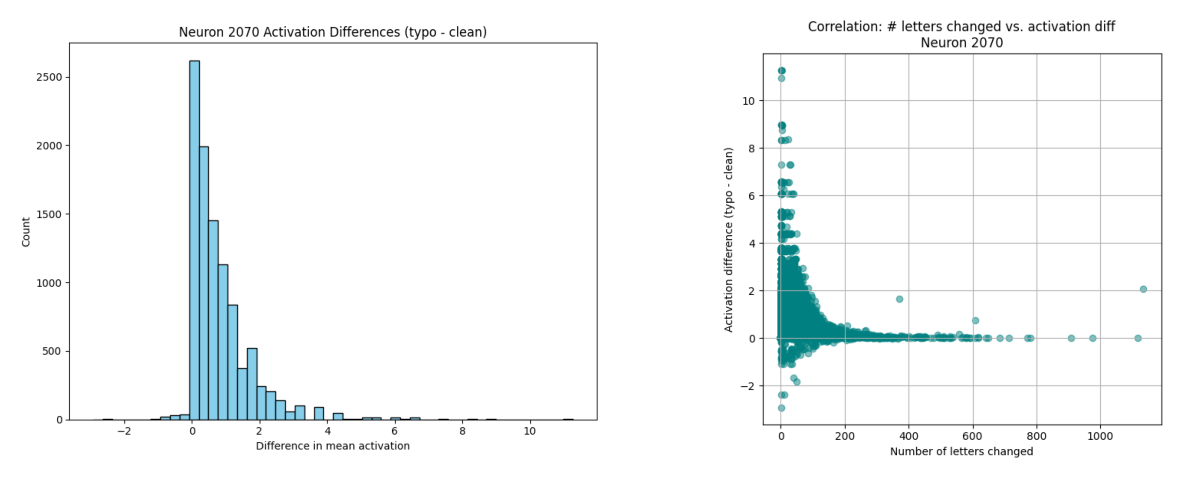

In [24]:
%run scripts/investigations/neuron_dissection.py

## 4. Neuron #2070 Ablation & Analysis

Zeroing out a single neuron can reveal how it contributes to text generation and perplexity. Here, we ablate neuron **#2070** in **layer 2**:

- **`neuron2070_ablation.py`** creates a forward hook that forces this neuron’s activation to zero. It then generates text normally vs. ablated and logs perplexities for each case, saving results (prompt, texts, perplexities) into a CSV file.
- **`analyze_neuron_ablation.py`** reads that CSV, computes summary statistics (e.g., average perplexities, fraction of changed text), and plots a histogram of `(ablated_perplexity - normal_perplexity)`.

The cells below to show how removing this single neuron affects model outputs!


In [30]:
# 1) Run the ablation script
!python neuron2070_ablation.py

# 2) Analyze results
!python analyze_neuron_ablation.py


=== Perplexity Stats ===
Number of samples read: 50
Mean normal perplexity:  6.129
Mean ablated perplexity: 6.204
Median normal perplexity:  5.752
Median ablated perplexity: 6.077

=== Perplexity Difference: ablated - normal ===
Mean difference:   0.075
Median difference: 0.253
Fraction of final text changed by ablation: 100.00%

Saved perplexity difference histogram to analyses_results/neuron2070_analysis/perplexity_diff_hist.png



## 5. Activation Patching with PC1

We’ll now explore how removing (or adding) the principal component (PC1) from a hidden layer affects text generation and perplexity. There are two scripts involved:

- **`run_dimension_causal_experiment_single.py`**  
  1. Chooses either the **"typo"** or **"clean"** dataset.  
  2. **Removes** the PC1 direction (i.e., subtracts the projection on `pc1_vector`) at layer 2 during forward passes, then compares normal text vs. dimension-removed text.  
  3. Optionally **adds** that PC1 vector if `PERFORM_ADD_TEST=True`.  
  4. Logs perplexities and final texts to a CSV in `analyses_results/`.

- **`analyze_causal_experiment.py`**  
  - Reads the CSV outputs for one or both datasets (clean/typo).
  - Computes average and median perplexities, plus the difference between normal vs. dimension-removed (or dimension-added).
  - Logs the results, highlighting how removing or adding PC1 shifts model performance.


# Run the dimension-removal script (model inference)
!python run_dimension_causal_experiment_single.py

# Analyze its CSV output
!python analyze_causal_experiment.py


In [31]:
!python scripts/investigations/activation_patching_dimension_evaluate.py
!python scripts/investigations/activation_patching_dimension.py


=== Starting analyze_causal_experiment.py ===
Analyzing CLEAN CSV: analyses_results/dimension_causal_XS_clean.csv
===== Analyzing analyses_results/dimension_causal_XS_clean.csv =====
Processed 1000 rows.
=== Normal vs RemoveDim ===
 normal perplexity:   mean=5.204, median=4.976
 removeDim perplexity: mean=5.223, median=4.917
 removeDim - normal:   mean=+0.019, median=+0.032
=== AddDim Stats ===
 addDim perplexity: mean=6.152, median=5.677
 addDim - normal:   mean=+0.948, median=+0.689
Analyzing TYPO CSV: analyses_results/dimension_causal_XS_typo.csv
===== Analyzing analyses_results/dimension_causal_XS_typo.csv =====
Processed 1000 rows.
=== Normal vs RemoveDim ===
 normal perplexity:   mean=6.324, median=5.903
 removeDim perplexity: mean=6.316, median=5.967
 removeDim - normal:   mean=-0.008, median=+0.002
=== AddDim Stats ===
 addDim perplexity: mean=7.475, median=6.905
 addDim - normal:   mean=+1.151, median=+0.896
=== Completed analyze_causal_experiment.py ===

